This notebook has two parts. 

(1) A demonstration that using siconca variable (i.e. sea ice pre-regridded onto a model's atmospheric grid) can give large errors in caluclated sea-ice area and extent. 

(2) A function to calculate sea-ice area and extent, on a dataset, given access to the grid cell areas for that model. 


Alistair Duffey, 01/08/23. alistair.duffey.21@ucl.ac.uk

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
#from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn import metrics

#sns.set()
from xmip.preprocessing import correct_lon
from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import replace_x_y_nominal_lat_lon
import matplotlib.path as mpath


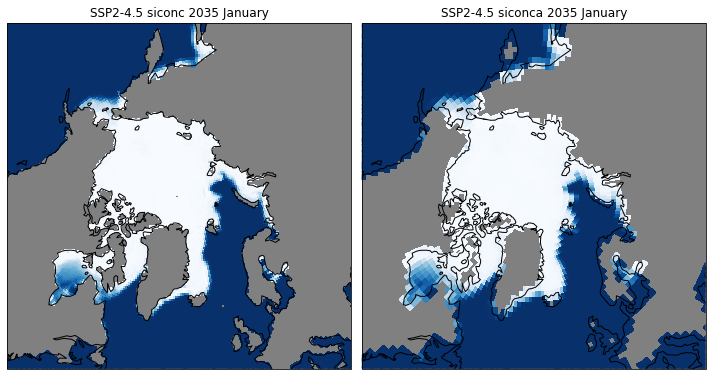

In [137]:

folder = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/SImon/siconc/gn/latest/'
file = 'siconc_SImon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_201501-204912.nc'
SI_ssp245_jan = xr.open_dataset(folder+file).sel(time='2035-01')#.sel(j=slice(250,331))

folder = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/SImon/siconca/gr/latest/'
file = 'siconca_SImon_UKESM1-0-LL_ssp245_r1i1p1f2_gr_201501-204912.nc'
SI_ssp245_jan_siconca = xr.open_dataset(folder+file).sel(time='2035-01')#.sel(j=slice(250,331))

fig, axs = plt.subplots(1, 2, figsize=(10, 6), 
                subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-30.0), 
                            'facecolor':'gray'})

#axs[0] = plt.axes()
#axs[1] = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-30.0), facecolor='gray')

p2 = SI_ssp245_jan.siconc[0].plot.pcolormesh(
    ax=axs[0],
    cmap='Blues_r',
    transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)

p3 = SI_ssp245_jan_siconca.siconca[0].plot.pcolormesh(
    ax=axs[1],
    cmap='Blues_r',
    transform=ccrs.PlateCarree(), x="lon", y="lat", add_colorbar=False
)

p2.axes.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
p2.axes.coastlines()   

p3.axes.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
p3.axes.coastlines()   

axs[0].set_title('SSP2-4.5 siconc 2035 January')
axs[1].set_title('SSP2-4.5 siconca 2035 January')
plt.tight_layout()
plt.savefig('Figures/siconc_vs_siconca_example.jpg', dpi=300)

In [138]:
# read in cell area data
areacello_file = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Ofx/areacello/gn/latest/areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacello = rename_cmip6(xr.open_dataset(areacello_file))
areacella_file = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/areacella/gn/latest/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacella = rename_cmip6(xr.open_dataset(areacella_file))

### multiplying by grid areas and summing produces large differences between ocean grid si conc and atmosphere grid

This means that the central cmip6 regridding of siconc onto atmospheric grid is not conservative of the sum. 

N.B. bumbers below are global, not arctic

In [139]:
SIao = np.nansum((SI_ssp245_jan.siconc[0].values/100)*(areacello.areacello.values/10**12))
SIao

16.354322696831748

In [140]:
SIaa = np.nansum((SI_ssp245_jan_siconca.siconca[0]/100).values*(areacella.areacella/10**12).values)
SIaa

19.215050613188744

In [141]:
print(np.round(100*(SIaa-SIao)/SIao, 0), '% differrence')

17.0 % differrence


In [142]:
mask = xr.where(SI_ssp245_jan.siconc>15, 1, 0)
SI_extent_ds = (mask*areacello.areacello.values/10**12).to_dataset(name='si_extent_Mkm2')
SIeo = np.nansum(SI_extent_ds.si_extent_Mkm2.values)
SIeo

21.131149251392

In [143]:
mask = xr.where(SI_ssp245_jan_siconca.siconca>15, 1, 0)
SI_extent_ds = (mask*areacella.areacella.values/10**12).to_dataset(name='si_extent_Mkm2')
SIea = np.nansum(SI_extent_ds.si_extent_Mkm2.values)
SIea

25.025692849664

In [146]:
folder = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/SImon/siconc/gn/latest/'
file = 'siconc_SImon_UKESM1-0-LL_ssp245_r1i1p1f2_gn_201501-204912.nc'
SI_ssp245 = replace_x_y_nominal_lat_lon(rename_cmip6(xr.open_dataset(folder+file)))

In [147]:
folder = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/SImon/siconca/gr/latest/'
file = 'siconca_SImon_UKESM1-0-LL_ssp245_r1i1p1f2_gr_201501-204912.nc'
SI_ssp245_siconca = rename_cmip6(xr.open_dataset(folder+file))

In [150]:
# we now define a new function to calculate area and extent only using siconc, with no regridding

def get_SIa_SI_e(ds, areacell_path=None, 
                 model=None, grid_type='ocean', 
                 var=None, siconc_in_percent=True,
                 hemisphere='NH', UKESM_MASS_data=False):
    """ function takes in a dataset containing siconc/siconca,
    and returns a timeseries dataset of sea ice area and extent 
    by hemisphere.  
    
    INPUTS
    ds: a dataset containing sea ice concentration
    areacell_path (optional): file path to cell areas .nc file
    model (optional): if no areacell_path, must specify a model to look up grid areas file on JASMSIN
    grid_type: 'ocean' (recommended) or 'atmosphere'. The only reason to use 'atmosphere' is to..
    .. compare the two options as the pre-computed cmip6 regridding does not conserve sea ice area or extent 
    var (optional): 'siconc' or 'siconca', but this is worked out from grid_type if not given
    siconc_in_percent: assumed true. This is not the case for direct MASS imported UKESM data
    hemisphere: 'NH' or 'SH', selects hemipshere for outputs.
    UKESM_MASS_data: True for data imported from MASS without CMIP6 CEDA processsing. Selecting..
    .. True means minor differences which break coordinate matching are accounted for. 
    """

    # make sure our naming conventions are correct, 
    # and that we have a nominal latitude with which to 
    # select hemisphere (nominal lat is not used otherwise) 
    if grid_type=='ocean':
        ds = replace_x_y_nominal_lat_lon(correct_lon(rename_cmip6(ds)))
    else:
        ds = rename_cmip6(ds)
                     
    # set up some dicts
    area_strings = {'ocean':'Ofx/areacello', 
                'atmosphere':'fx/areacella'}
                     
    var_strings = {'ocean':'siconc',
                   'atmosphere':'siconca'}
    cell_area_var_strings = {'ocean':'areacello',
                             'atmosphere':'areacella'}
    hemisphere_slices = {'NH':[0, 90],
                         'SH':[-90, 0]}
                     
    # select variable names:
    if not var:        
        var = var_strings[grid_type]
    cell_area_var = cell_area_var_strings[grid_type]
        
    # find grid cell area filepath (on jasmin):
    if not areacell_path:
        folder = glob.glob('/badc/cmip6/data/CMIP6/CMIP/*/{m}/*/*/{a}/*/latest/'.format(
                    m=model, a=area_strings[grid_type]))[0]
        file = os.listdir(folder)[0]
        areacell_path = folder+file
       
    # read in cell_areas
    cell_areas = rename_cmip6(xr.open_dataset(areacell_path))
    if grid_type=='ocean':
        cell_areas = replace_x_y_nominal_lat_lon(correct_lon(cell_areas))
    
    # convert si concentration into fraction if in percent
    if siconc_in_percent:
        ds[var] = ds[var]*0.01

    # define unit conversion m2 to M_km2:
    unit_conv = 10**12

    # select hemipshere and calc area and extent
    lats = hemisphere_slices[hemisphere]                 
    ds = ds.sel(y=slice(lats[0], lats[1]))
    cell_areas = cell_areas.sel(y=slice(lats[0], lats[1])) 

    # need to cheat slightly for the UKESM runs that are direct exports from MASS
    # this code accounts for v slight differences in nominal lat/lon as calculated by xmip
    # use with caution!! 

    if UKESM_MASS_data:
        # check validity of replacing coords:
        if np.max((ds.y - cell_areas.y) > 0.1):
            print('WARNING: replacing coords in ds with significantly different ones from cell areas.')
        if np.max((ds.x - cell_areas.x) > 0.1):
            print('WARNING: replacing coords in ds with significantly different ones from cell areas.')
        ds['x'] = cell_areas.x
        ds['y'] = cell_areas.y

    SI_area = ds[var]*cell_areas[cell_area_var]/unit_conv
    SI_area = SI_area.sum(dim=['x', 'y']).to_dataset(name='si_area_{}_Mkm2'.format(hemisphere))

    SI_extent_mask = xr.where(ds[var]>0.15, 1, 0)
    SI_extent = SI_extent_mask*cell_areas[cell_area_var]/unit_conv
    SI_extent = SI_extent.sum(dim=['x', 'y']).to_dataset(name='si_extent_{}_Mkm2'.format(hemisphere))                 

    out_ds = xr.merge([SI_area, SI_extent])
    return out_ds


In [151]:
siconc = get_SIa_SI_e(SI_ssp245, areacell_path=None, 
                 model='UKESM1-0-LL', grid_type='ocean', 
                 var=None, siconc_in_percent=True,
                 hemisphere='NH')
siconca = get_SIa_SI_e(SI_ssp245_siconca, areacell_path=None, 
                 model='UKESM1-0-LL', grid_type='atmosphere', 
                 var=None, siconc_in_percent=True,
                 hemisphere='NH')

Text(0.5, 1.0, 'Arctic sea-ice area, UKESM1-0-LL, SSP245')

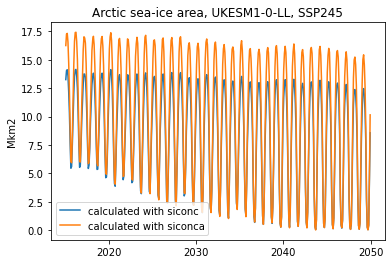

In [155]:
plt.plot(siconc.time, siconc['si_area_NH_Mkm2'].values, label='calculated with siconc')
plt.plot(siconca.time, siconca['si_area_NH_Mkm2'].values, label='calculated with siconca')
plt.legend()
plt.ylabel('Mkm2')
plt.title('Arctic sea-ice area, UKESM1-0-LL, SSP245')

Text(0.5, 1.0, 'Arctic sea-ice, IPSL-CM6A-LR, G6sulfur')

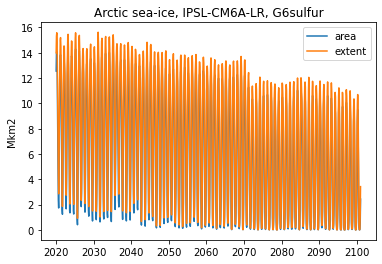

In [158]:
# try with annother model
x = '/badc/cmip6/data/CMIP6/GeoMIP/IPSL/IPSL-CM6A-LR/G6sulfur/r1i1p1f1/SImon/siconc/gn/latest/'
y = 'siconc_SImon_IPSL-CM6A-LR_G6sulfur_r1i1p1f1_gn_202001-210012.nc'
ds = xr.open_dataset(x+y)
mod = 'IPSL-CM6A-LR'
SI = get_SIa_SI_e(ds, areacell_path=None, 
                 model=mod, grid_type='ocean', 
                 var=None, siconc_in_percent=True,
                 hemisphere='NH', UKESM_MASS_data=False)
plt.plot(SI.time, SI['si_area_NH_Mkm2'].values, label='area')
plt.plot(SI.time, SI['si_extent_NH_Mkm2'].values, label='extent')
plt.legend()
plt.ylabel('Mkm2')
plt.title('Arctic sea-ice, IPSL-CM6A-LR, G6sulfur')